In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn import metrics
import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Load Validation Data

In [6]:
X_val_shuff = np.load('Te_X_val_shuff_20200820.npy')
Y_val_shuff = np.load('Te_Y_val_shuff_20200820.npy')

## No wrong labels

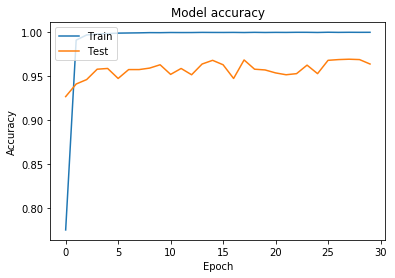

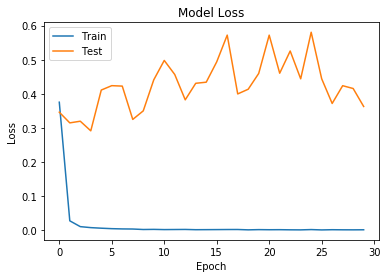

In [3]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [4]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [5]:
modelE.load_weights('savio_nets/chirality_classification_00pwrongleftrightlabels_weights_20200821.h5')

In [7]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 34ms/step - loss: 0.7770 - accuracy: 0.9381


[0.7769570350646973, 0.938144326210022]

## 5% wrong labels

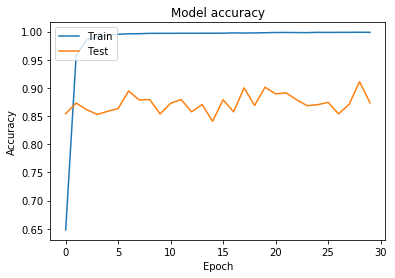

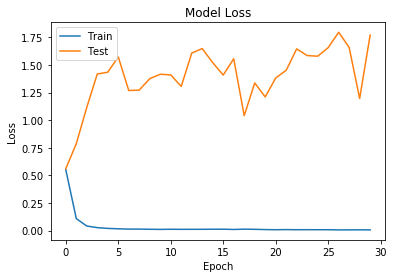

In [8]:
history = h5py.File('savio_nets/chirality_classification_05pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
modelE.load_weights('savio_nets/chirality_classification_05pwrongleftrightlabels_weights_20200821.h5')

In [10]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 35ms/step - loss: 0.9083 - accuracy: 0.9330


[0.9082961678504944, 0.9329897165298462]

## 10% Wrong Labels

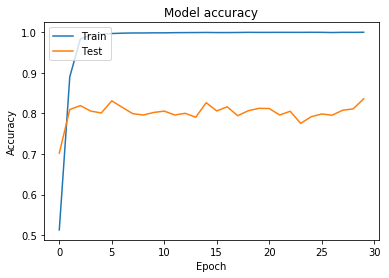

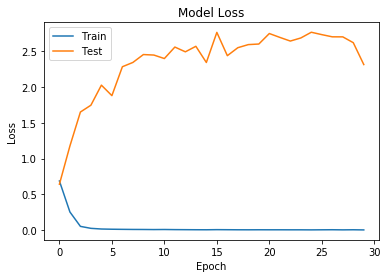

In [12]:
history = h5py.File('savio_nets/chirality_classification_10pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
modelE.load_weights('savio_nets/chirality_classification_10pwrongleftrightlabels_weights_20200821.h5')

In [14]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 35ms/step - loss: 1.2254 - accuracy: 0.9124


[1.225423812866211, 0.9123711585998535]

## 20% wrong labels increased samples per epoch

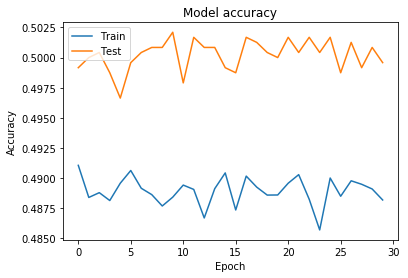

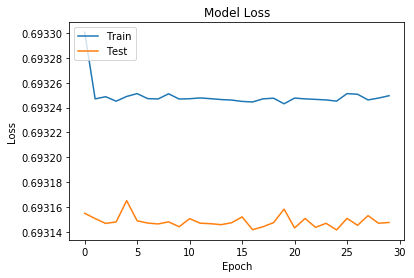

In [15]:
history = h5py.File('savio_nets/chirality_classification_20pwrongleftrightlabels_history_20200821_v3.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
modelE.load_weights('savio_nets/chirality_classification_20pwrongleftrightlabels_weights_20200821_v3.h5')

In [17]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 33ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931473016738892, 0.5]